In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image

In [2]:
import sys

import warnings
warnings.filterwarnings('ignore')

print('python', '%s.%s.%s' % sys.version_info[:3])

for mod in tf, cv2:
    print(mod.__name__, mod.__version__)


python 3.12.7
tensorflow 2.19.0
cv2 4.11.0


In [3]:
images = glob("fer2013/train/**/**")
for i in range(5):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [4]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("fer2013/train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("fer2013/test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [6]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [7]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))
    conv_4 = Convolution(conv_3,256,(5,5))

    flatten = Flatten()(conv_4)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(7, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model

In [8]:
model = model_fer((48,48,1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,08

 Total params: 1,539,719 (5.87 MB)

 Trainable params: 1,538,247 (5.87 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [9]:
epochs = 500
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

In [10]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.2930 - loss: 1.8773
Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 169s 372ms/step - accuracy: 0.2932 - loss: 1.8769 - val_accuracy: 0.4259 - val_loss: 1.4837
Epoch 2/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:46 238ms/step - accuracy: 0.4844 - loss: 1.4523
Epoch 2: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4844 - loss: 1.4523 - val_accuracy: 0.4301 - val_loss: 1.4676
Epoch 3/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.4511 - loss: 1.4419
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 150s 336ms/step - accuracy: 0.4512 - loss: 1.4418 - val_accuracy: 0.4947 - val_loss: 1.3079
Epoch 4/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:51 248ms/step - accuracy: 0.5781 - loss: 1.4584
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5781 - loss: 1.4584 - val_accuracy: 0.4965 - val_loss: 1

In [16]:
model_fer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 20
history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)

Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9367 - loss: 0.1800
Epoch 1: saving model to model.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 88s 192ms/step - accuracy: 0.9367 - loss: 0.1800
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9432 - loss: 0.1673
Epoch 2: saving model to model.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 87s 193ms/step - accuracy: 0.9432 - loss: 0.1673
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9418 - loss: 0.1696
Epoch 3: saving model to model.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 90s 200ms/step - accuracy: 0.9418 - loss: 0.1696
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9403 - loss: 0.1704
Epoch 4: saving model to model.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 94s 209ms/step - accuracy: 0.9403 - loss: 0.1704
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9435 - loss: 0.1626
Epoch 5: saving model to model.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms

In [11]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6246 - loss: 2.0219


[2.006542921066284, 0.631234347820282]

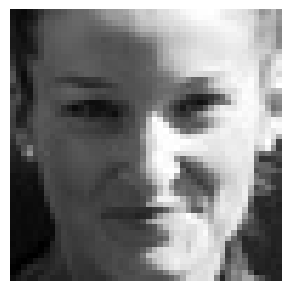

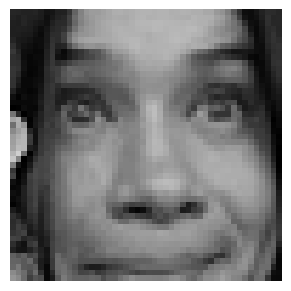

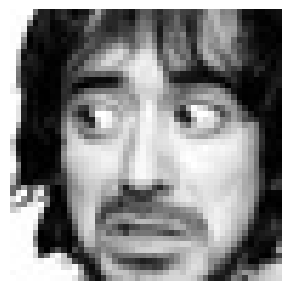

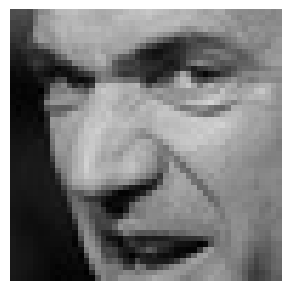

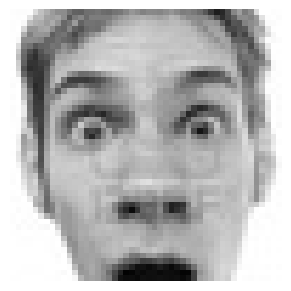

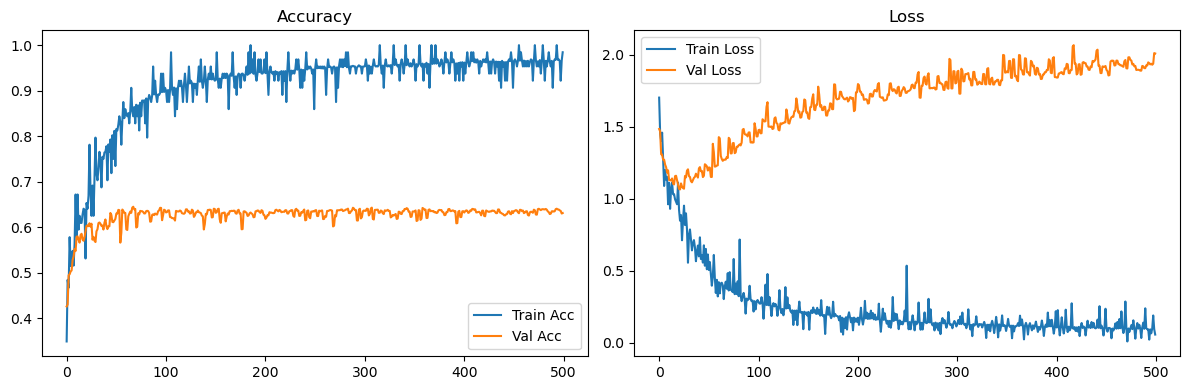

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6415 - loss: 1.8744
Final Test Accuracy: 63.12%


In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Final Accuracy
loss, acc = model.evaluate(validation_generator)
print(f"Final Test Accuracy: {acc*100:.2f}%")

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [25]:
model.save('Emotion_Detection.h5')